In [12]:
import numpy as np
from torch import optim, nn, Tensor
from torch.nn import functional as F
import torch
import wandb
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer
import transformers
import lightning as L
from inspect import signature, _ParameterKind
import copy
import gc
import datasets
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import WandbLogger

In [2]:
if torch.cuda.get_device_capability()[0] >= 8:
    torch.set_float32_matmul_precision('medium')

In [3]:
wandb.login(key='os.environ[WANDB_API_KEY]', relogin=True)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/wwu/.netrc


True

In [4]:
class ComposeModule(nn.Module):
    def __init__(self, modules):
        super().__init__()
        self.module_list = nn.ModuleList(modules)
    def forward(self, x):
        for m in self.module_list:
            x = m(x)
        return x

In [5]:
class LitWPEModel(L.LightningModule):
    '''
    Train only position encodings.
    '''
    def __init__(
        self,
        model_name='gpt2',
        lr=1e-4,
        lr_scheduler_name='constant_with_warmup',
        seq_len=64,
        num_warmup_steps=5000,
        wpe_rank=10,
    ):
        super().__init__()
        args = vars()
        for param in list(signature(LitWPEModel.__init__).parameters)[1:]:
            setattr(self, param, args[param])
        self.model = AutoModelForCausalLM.from_pretrained(self.model_name)
        U, S, V = torch.svd(self.model.transformer.wpe.weight)
        print(f'Reducing wpe to rank {wpe_rank}')
        print((torch.sum(S[:wpe_rank] ** 2) / torch.sum(S ** 2)).item(), 'variance explained')
        self.wpe_A = nn.Embedding(seq_len, wpe_rank)
        self.wpe_B = nn.Linear(wpe_rank, self.model.transformer.embed_dim, bias=False)
        self.wpe_B.weight = nn.Parameter(V[:wpe_rank].T.clone())
        self.wpe_B.weight.requires_grad = False
        self.model.transformer.wpe = ComposeModule([self.wpe_A, self.wpe_B])
        for name, param in self.model.named_parameters():
            if 'wpe' not in name:
                param.requires_grad = False
        self.save_hyperparameters()

    def forward(self, batch):
        return self.model.forward(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            labels=batch['input_ids'],
            use_cache=True,
        )

    def training_step(self, batch, batch_idx):
        loss = self.forward(batch).loss
        self.log('train_loss', loss.item(), on_step=True)
        self.log('global_step', self.trainer.global_step)
        return loss

    def _log_wpe(self):
        for i in range(self.seq_len):
            self.log(f'wpe_norm_{i}', self.model.transformer.wpe.module_list[0].weight[i].norm().item())

    def validation_step(self, batch, batch_idx):
        loss = self.forward(batch).loss
        self.log('val_loss', loss.item())
        #self._log_wpe()
        return loss

    def test_step(self, batch, batch_idx):
        loss = self.forward(batch).loss
        self.log('test_loss', loss.item())
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(
            params=self.model.parameters(),
            lr=self.lr,
        )
        scheduler = transformers.get_scheduler(
            name=self.lr_scheduler_name,
            optimizer=optimizer,
            num_warmup_steps=self.num_warmup_steps,
            num_training_steps=self.trainer.estimated_stepping_batches,
        )
        # HF's schedulers are on 'step' interval (I think)
        return (
            [optimizer],
            [{"scheduler": scheduler, "interval": "step"}]
        )

    def on_save_checkpoint(self, checkpoint):
        # Only save wpe
        for k in list(checkpoint['state_dict'].keys()):
            if 'wpe' not in k:
                checkpoint['state_dict'].pop(k)

In [6]:
NAME = 'GPT2-WPE-RANK10'
PROJ = 'LAISR_FUTURE_GPT2'

In [7]:
train = datasets.load_from_disk('/workspace/corpus/msmarco/msmarco_GPT2_64tokens_1m/train').with_format('torch')
val = datasets.load_from_disk('/workspace/corpus/the_pile/the_pile_500k_64_GPT2/Enron Emails/val').with_format('torch')
train_loader = DataLoader(train, batch_size=128)
val_loader = DataLoader(val, batch_size=128, num_workers=111)

In [8]:
wandb_logger = WandbLogger(
    name=NAME,
    project=PROJ,
    log_model=False,   # Only save checkpoints locally
)

In [9]:
checkpoint_callback = ModelCheckpoint(
    dirpath="/workspace/checkpoints",
    filename=NAME + "_{global_step}_{val_loss:.2f}",
    every_n_epochs=1,
    save_top_k=-1,
    monitor='val_loss',
    mode='min',
)
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    divergence_threshold=15,
    min_delta=0.00,
    patience=10,
    verbose=False,
    mode='min',
)
trainer = L.Trainer(
    fast_dev_run=False,
    logger=wandb_logger,
    val_check_interval=.25,
    callbacks=[checkpoint_callback, early_stop_callback],
    max_epochs=1000,
    enable_progress_bar=True,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:
model = LitWPEModel()
wandb_logger.watch(model.model.transformer.wpe, log='all')

wandb: Currently logged in as: wilswu. Use `wandb login --relogin` to force relogin


Reducing wpe to rank 10
0.9881356358528137 variance explained


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [ ]:
trainer.fit(
    model=model,
    train_dataloaders=train_loader,#loaders['train'],
    val_dataloaders=val_loader,#loaders['val']
)

/home/wwu/.local/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /workspace/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
/home/wwu/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=111` in the `DataLoader` to improve performance.

  | Name  | Type            | Params
------------------------------------------
0 | model | GPT2LMHeadModel | 123 M 
1 | wpe_A | Embedding       | 640   
2 | wpe_B | Linear          | 7.7 K 
------------------------------------------
640       Trainable params
123 M     Non-trainable params
123 M     Total params
494.647   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/wwu/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 128. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/wwu/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 24. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

In [61]:
gpt = AutoModelForCausalLM.from_pretrained('gpt2')

In [62]:
U, S, V = torch.svd(gpt.transformer.wpe.weight.detach())

In [27]:
V.shape

torch.Size([768, 768])

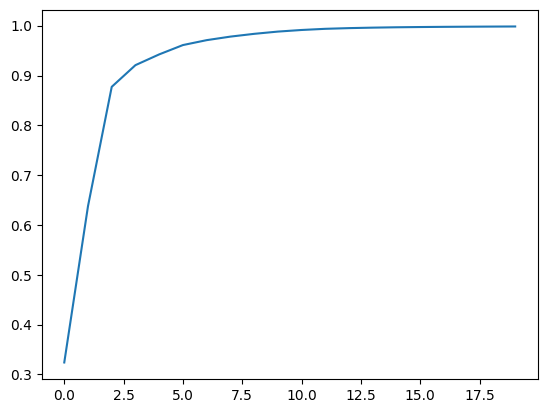

In [22]:
plt.plot(np.cumsum(S ** 2)[:20] / np.sum(S ** 2))
plt.show()

In [23]:
np.cumsum(S ** 2)[:20] / np.sum(S ** 2)

array([0.32412422, 0.63785124, 0.87728685, 0.9208193 , 0.94238114,
       0.96109253, 0.9709498 , 0.97805434, 0.98361284, 0.9881355 ,
       0.9913601 , 0.99370223, 0.9951004 , 0.99606305, 0.99679196,
       0.9972813 , 0.997665  , 0.99794954, 0.99818176, 0.9983916 ],
      dtype=float32)

In [5]:
from glob import glob
import re

In [2]:
ckpts = glob('/workspace/checkpoints/GPT2-WPE-RANK10*')

In [9]:
ckpts = {
    int(re.findall('global_step=(\d+)', ckpt)[0]): ckpt
    for ckpt in ckpts
}

In [16]:
A = torch.load(ckpts[286553])['state_dict']['model.transformer.wpe.module_list.0.weight']

In [17]:
U, S, V = torch.svd(A)

In [34]:
A = A.cpu().numpy()

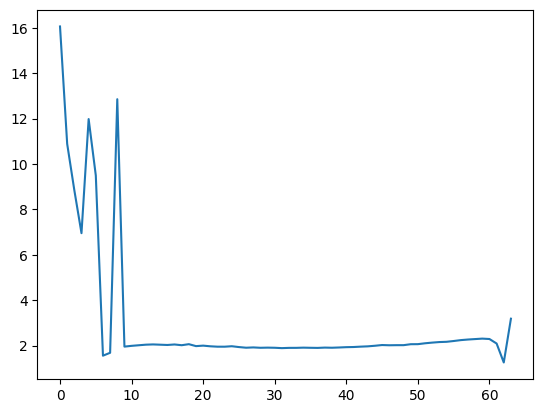

In [37]:
plt.plot(np.linalg.norm(A, axis=1))
plt.show()

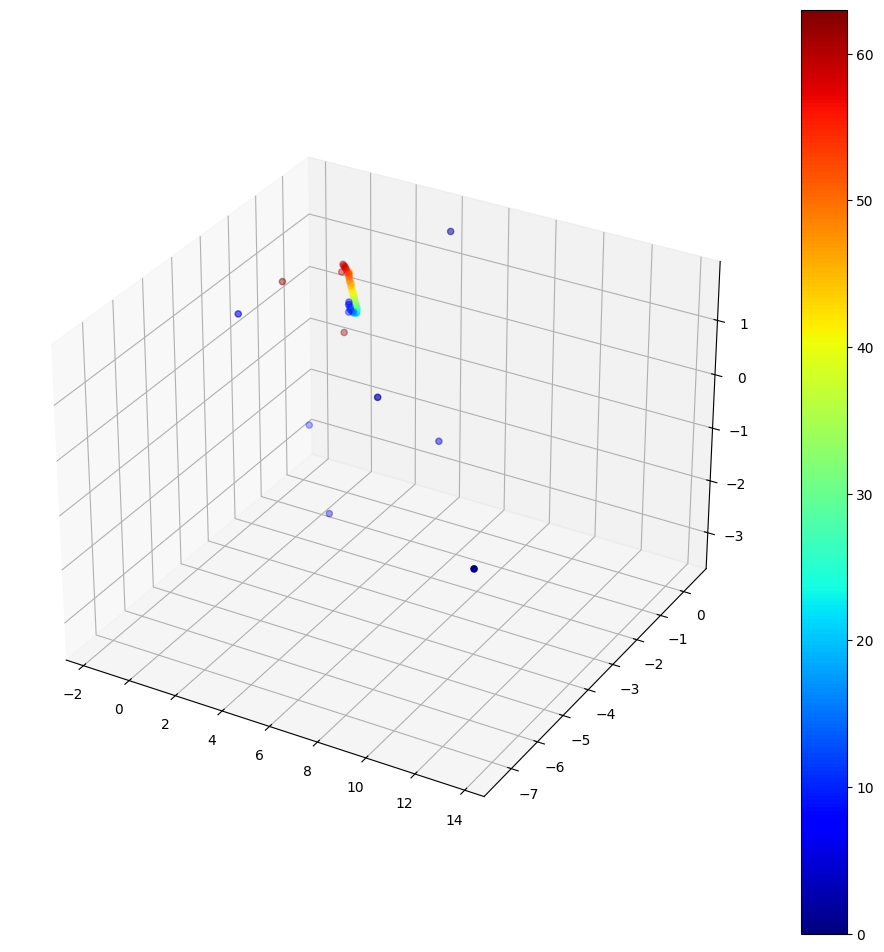

In [35]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
plot = ax.scatter(A[:,0], A[:,1], A[:,2], cmap='jet', c=range(64))
fig.colorbar(plot)
plt.show()